In [1]:
# Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import seaborn as sns
import pickle
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
# import helper functions
import sys
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *
%matplotlib inline

from sklearn.metrics import roc_curve, auc


"""
nb_extensions
https://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md
https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md
"""

'\nnb_extensions\nhttps://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md\nhttps://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md\n'

# List the files of saved models


In [3]:
# Path
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [18]:
os.listdir(saved_models_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.h5',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.h5',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.h5']

In [4]:
os.listdir(checkpoint_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.index',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'checkpoint',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_o

In [5]:
os.listdir(training_history_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.pickle',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model2_sample_sizeall_epoch50_dense2_losswbc_history_log.csv',
 'model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log.csv',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_lo

# Set the parameter

In [19]:
weights='model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned.csv'

number_of_images = 15000

history=weights+'.pickle'

In [20]:
# Create train-test dataset
#name_of_model='model1_sample_sizeall_epoch50_dense2_losswbc'
# Test train split, plus the features that are used to binarize the data
X_train, X_val, y_train_bin, y_val_bin, features = train_test_split_custom(number_of_images, csv)


# Load the model

## Option 1 : load the saved model:

In [21]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [ ]:
# Architecture
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

transfer_layer = vgg.get_layer('block5_pool')

# cutting of the end of the model before the dense layers
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

# freeze VGG
conv_model.trainable = False

num_label = y_train_bin.shape[1]

def create_model():
    # Start a new Keras Sequential model.
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(conv_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(num_label, activation='sigmoid'))
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model


new_model=create_model()



In [8]:
# Checkpoint path
# For weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [22]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 112)               1

# Predictions for the test dataset

In [23]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [25]:
# Make the predictions
#%%time
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds
predictions_test = new_model.predict(val_ds)
#predictions_train = new_model.predict(train_ds)

# SAVE the prediction
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )

In [ ]:
# Optional step - load the predictions from file
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )
# Load the prediction
#predictions_test= pickle.load( open( "predictions.p", "rb" ) )

# Evaluations

## Loss plots

In [26]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))

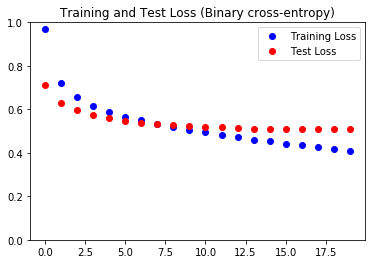

In [27]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9105ce7e48>)

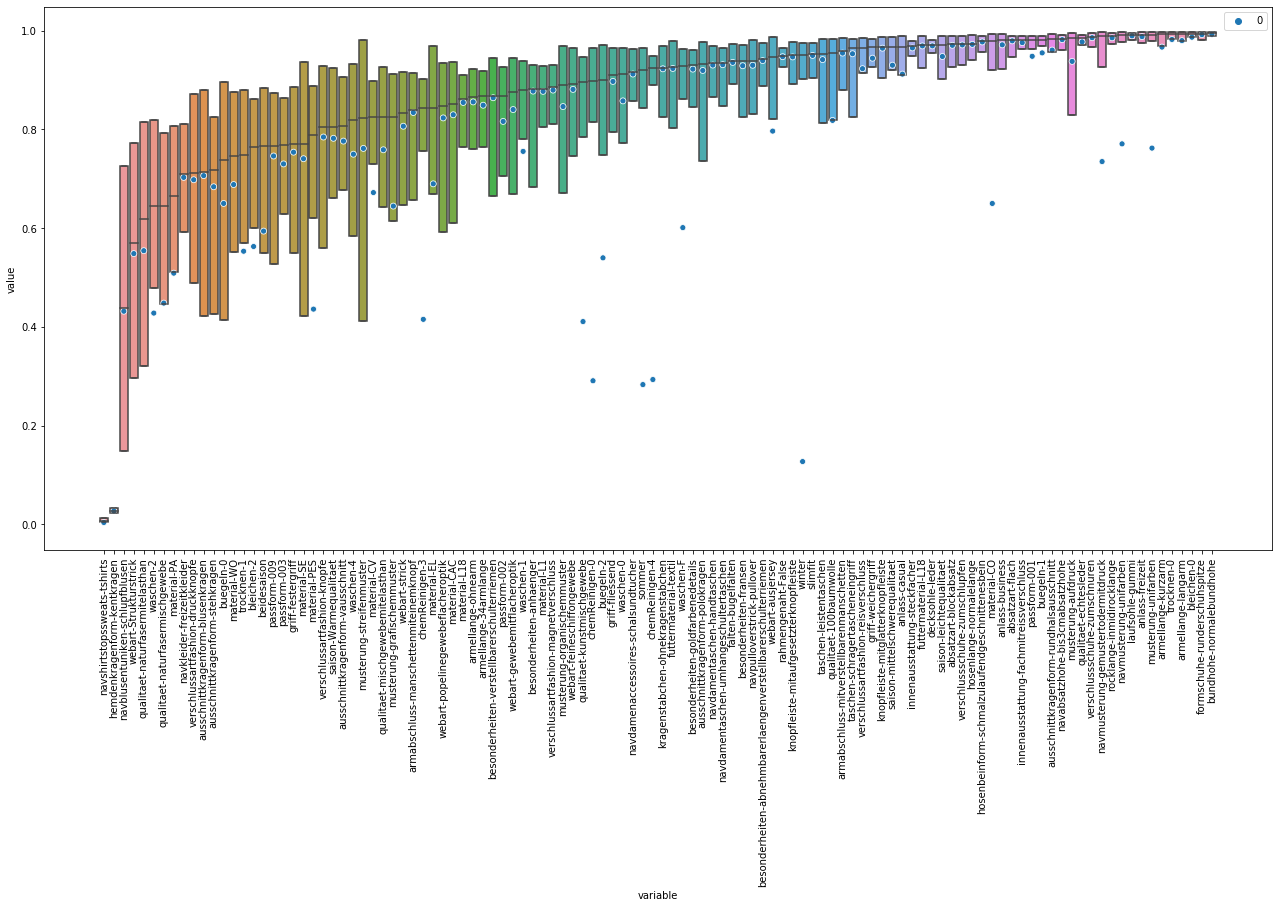

In [32]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features, diff=True)

## Recall on 1, recall on 0

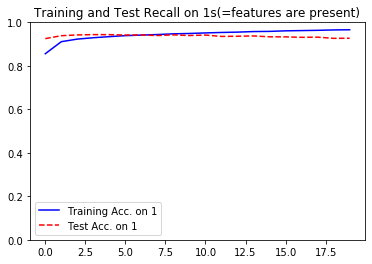

In [33]:
plot_training_history_recall_on_one(history)

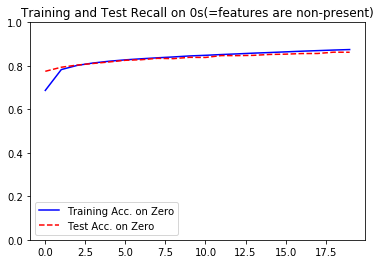

In [34]:
plot_training_history_recall_on_zero(history)

# Precision

In [ ]:
plot_training_history_precision_on_one(history)

## Make a prediction for an image

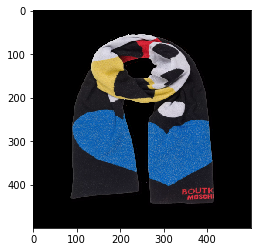

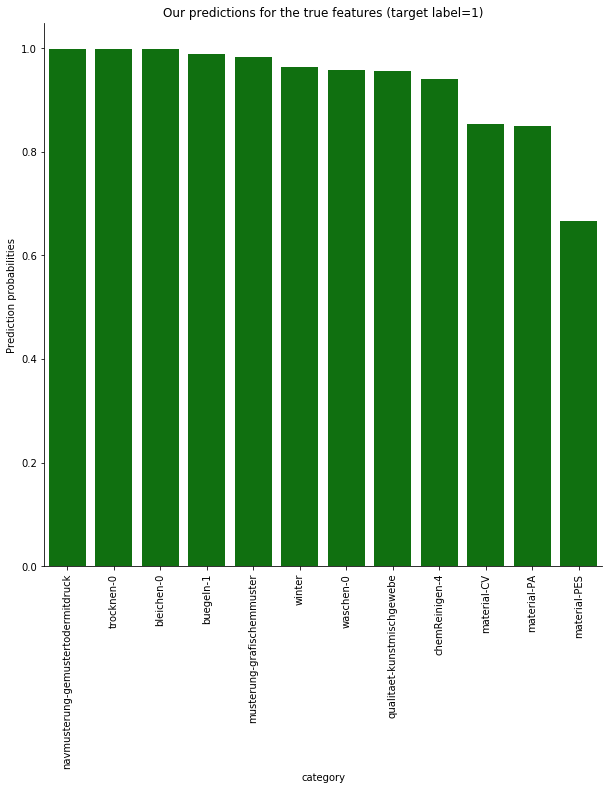

In [36]:
doPrediction(0, features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(1,features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(3,features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(4,features, X_val, y_val_bin, predictions_test)

## ROC AUC curve

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f91048a8c18>)

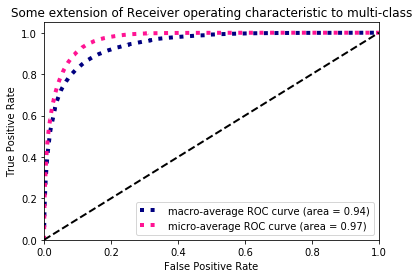

In [37]:
grouped_roc(y_val_bin, predictions_test)

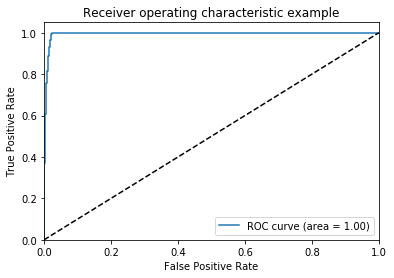

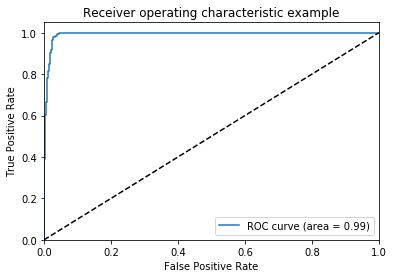

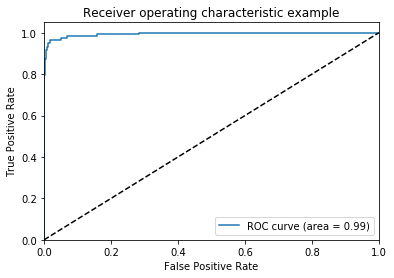

In [38]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [40]:
# ROC AUC scores per feature
for i in range(112):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

{0: 0.995178075108267,
 1: 0.993518971784483,
 2: 0.99394841153154,
 3: 0.9620887301074054,
 4: 0.9983028139428434,
 5: 0.9748216207818725,
 6: 0.9898756586152202,
 7: 0.9599486818642953,
 8: 0.9893539311683507,
 9: 0.9924538757082478,
 10: 0.9874250242372803,
 11: 0.9672627544215172,
 12: 0.9841140192004925,
 13: 0.9646330425351394,
 14: 0.9344949907469883,
 15: 0.9433306130286592,
 16: 0.8909761296363035,
 17: 0.9824394573348548,
 18: 0.9811202978290773,
 19: 0.9819084218977593,
 20: 0.9685328967682173,
 21: 0.9782103448275862,
 22: 0.9508738917185436,
 23: 0.8791259673025865,
 24: 0.8958600801431683,
 25: 0.8884759075346808,
 26: 0.8841761800332026,
 27: 0.9959594168636722,
 28: 0.8548209090298049,
 29: 0.8412503446719974,
 30: 0.8284906922064754,
 31: 0.9864643075489826,
 32: 0.985354927636113,
 33: 0.9949793453148644,
 34: 0.9891465444898622,
 35: 0.9815130544196289,
 36: 0.930557057325129,
 37: 0.9634051584318005,
 38: 0.942823366526439,
 39: 0.9753168779186124,
 40: 0.9946998644